# Classwork

In [ ]:
from google.colab import drive

drive.mount('drive')

Mounted at drive


In [ ]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download --unzip ronitf/heart-disease-uci

  0% 0.00/3.40k [00:00<?, ?B/s]
100% 3.40k/3.40k [00:00<00:00, 3.00MB/s]


In [ ]:
#Important imports
import torch
from torch import nn as nn # for NN
from torch.utils.data import Dataset # class to create dataset class
from torch import optim # Optimizer
from torch.nn import functional as F # activation functions
import matplotlib.pyplot as plt # to plot a graph
import pandas as pd # py data analysis

#Choosing devise to be gpu if have one, else cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Creating DataSet class with which we will transform our tabelar data into tensors
class DataSet(Dataset):

    def __init__(self,path):  
        #transformed csv file into tensor
        self.dataset = torch.tensor(pd.read_csv(path).values)

    def __len__(self):
        #return lenght of dataset
        return len(self.dataset)

    def __getitem__(self, i):
        #returns X and Y data by index
        return self.dataset[i,:-1], self.dataset[i,-1]            ## mb add transformation that normalizes

In [ ]:
class Net(nn.Module):

    def __init__(self, n_features):
        super().__init__()
        #Setting number of initial features, which will be equal to number of features in dataset
        self.n_features = n_features
        
        #self.norm = nn.LayerNorm(n_features)
        #Setting some layers for our architecture
        self.fc1 = nn.Linear(self.n_features,16) # (input, ouput)
        self.fc2 = nn.Linear(16,32) # (input, ouput)
        self.fc3 = nn.Linear(32,1)  # (input, ouput)           

    def forward(self,x):
        #Running forward cycle of our network
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))
        
        #returning ouput
        return out

In [ ]:
# Training loop for our network
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot=True):

    #Initializing two lists to save accuracy to plot them later
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    #Going thru every epoch
    for epoch in range(n_epochs):

        #Going thru example, thru every batch, in our case, thru all data at once
        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            # running our data thru our data - forward
            output = model(example.float())
            # Getting loss of our network right now
            loss = loss_fn(output, labels.float())

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()
            
            
        with torch.no_grad():
            
            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total

        if (epoch+1) % 10 ==0:
            print(f'Epoch {epoch+1})', 
                  f'Train Accuracy: {train_accuracy[epoch]}',
                  f'Test Accuracy: {test_accuracy[epoch]}')

    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs = range(n_epochs)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#Creating Dataset from csv file
data = DataSet('heart.csv')

#Saving nr of examples and calculating number of validation samples
n_samples = len(data)
n_test = int(0.2*n_samples)

#Spliting into train and validation
train_set, test_set = torch.utils.data.random_split(data,  [n_samples-n_test, n_test])


# running train and validation sets thru dataloader that helps with parallelizing the data loading process with automatic batching
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=len(test_set), shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10) Train Accuracy: 0.6213991641998291 Test Accuracy: 0.6166666746139526
Epoch 20) Train Accuracy: 0.6255143880844116 Test Accuracy: 0.6166666746139526
Epoch 30) Train Accuracy: 0.7160493731498718 Test Accuracy: 0.6666666865348816
Epoch 40) Train Accuracy: 0.7366254925727844 Test Accuracy: 0.6833333373069763
Epoch 50) Train Accuracy: 0.7325102686882019 Test Accuracy: 0.6499999761581421
Epoch 60) Train Accuracy: 0.7366254925727844 Test Accuracy: 0.7166666388511658
Epoch 70) Train Accuracy: 0.7448559403419495 Test Accuracy: 0.7333333492279053
Epoch 80) Train Accuracy: 0.748971164226532 Test Accuracy: 0.75
Epoch 90) Train Accuracy: 0.7530864477157593 Test Accuracy: 0.75
Epoch 100) Train Accuracy: 0.7736625671386719 Test Accuracy: 0.7166666388511658
Epoch 110) Train Accuracy: 0.7860082387924194 Test Accuracy: 0.75
Epoch 120) Train Accuracy: 0.7942386865615845 Test Accuracy: 0.7333333492279053
Epoch 130) Train Accuracy: 0.798353910446167 Test Accuracy: 0.75
Epoch 140) Train Accuracy: 

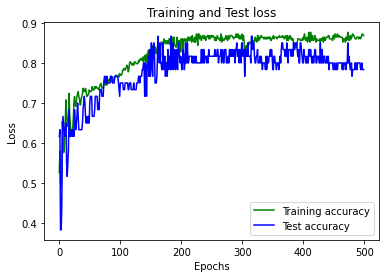

In [ ]:
#Setting some hyperparameters and parameters
learning_rate = 1e-2

#Initializing model with nr of features from input
model = Net(len(data[0][0])).to(DEVICE)

#Optimizer and loss funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

#Running training loop on the data with set parameters
training_loop(
    n_epochs=500,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10) Train Accuracy: 0.4938271641731262 Test Accuracy: 0.4000000059604645
Epoch 20) Train Accuracy: 0.6584362387657166 Test Accuracy: 0.6166666746139526
Epoch 30) Train Accuracy: 0.6995884776115417 Test Accuracy: 0.6499999761581421
Epoch 40) Train Accuracy: 0.7037037014961243 Test Accuracy: 0.6499999761581421
Epoch 50) Train Accuracy: 0.7407407164573669 Test Accuracy: 0.699999988079071


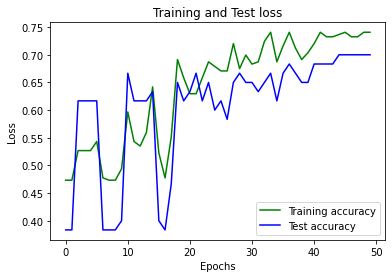

In [ ]:
#Setting some hyperparameters and parameters
learning_rate = 1e-2

#Initializing model with nr of features from input
model = Net(len(data[0][0])).to(DEVICE)

#Optimizer and loss funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

#Running training loop on the data with set parameters
training_loop(
    n_epochs=50,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

# Homework

In [ ]:
from google.colab import drive

drive.mount('drive')

Mounted at drive


In [ ]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download --unzip uciml/pima-indians-diabetes-database

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
#Important imports
import torch
from torch import nn as nn # for NN
from torch.utils.data import Dataset # class to create dataset class
from torch import optim # Optimizer
from torch.nn import functional as F # activation functions
import matplotlib.pyplot as plt # to plot a graph
import pandas as pd # py data analysis

#Choosing devise to be gpu if have one, else cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class DataSet(Dataset):

    def __init__(self,path):  
        self.dataset = torch.tensor(pd.read_csv(path).values)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.dataset[i,:-1], self.dataset[i,-1]         

In [ ]:
class Net(nn.Module):

    def __init__(self, n_features):
        super().__init__()
        self.n_features = n_features
        
       # self.norm = nn.LayerNorm(self.n_features)
        self.fc1 = nn.Linear(self.n_features, 8) 
        self.fc2 = nn.Linear(8,16) 
        self.fc3 = nn.Linear(16,32)           
        self.fc4 = nn.Linear(32,64)   
        self.fc5 = nn.Linear(64,128)
        self.fc6 = nn.Linear(128,1)  

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = F.relu(self.fc5(out))
        out = F.sigmoid(self.fc6(out))
        
        return out

In [81]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot=True):

    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)
    train_loss = torch.zeros(n_epochs)
    test_loss = torch.zeros(n_epochs)

    for epoch in range(n_epochs):
        running_loss = 0
        for example, labels in train_loader:     

            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            labels  = labels.unsqueeze(1)

            output = model(example.float())

            loss = loss_fn(output, labels.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

           # running_loss += loss.item()
            
            
        with torch.no_grad():
            
            for loader, accuracy, loss in [(train_loader, train_accuracy, train_loss),(test_loader, test_accuracy, test_loss)]:
                correct = 0
                total = 0
                loss2 = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    loss1 = loss_fn(outputs, labels.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()
                    loss2 += loss1.item()

                accuracy[epoch] = correct / total
                loss[epoch] = loss1 / total

        if (epoch+1) % 10 ==0:
            print(f'Epoch {epoch+1}', 
                  f'Train Accuracy: {train_accuracy[epoch]}',
                  f'Test Accuracy: {test_accuracy[epoch]}',
                  f'Train Loss: {train_loss[epoch]}',
                  f'Test Loss: {test_loss[epoch]}')

    if print_plot:

        epochs = range(n_epochs)

        
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.plot(epochs, train_loss, 'g', label='Training loss')
        plt.plot(epochs, test_loss, 'b', label='Test loss')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [73]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


data = DataSet('diabetes.csv')

n_samples = len(data)
n_test = int(0.2*n_samples)

train_set, test_set = torch.utils.data.random_split(data,  [n_samples-n_test, n_test])


train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6487804651260376 Test Accuracy: 0.6601307392120361 Train Loss: 0.0011071545304730535 Test Loss: 0.0044623734429478645
Epoch 20 Train Accuracy: 0.6487804651260376 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010845394572243094 Test Loss: 0.004363954998552799
Epoch 30 Train Accuracy: 0.6520324945449829 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010597392683848739 Test Loss: 0.004226365592330694
Epoch 40 Train Accuracy: 0.6520324945449829 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010340192820876837 Test Loss: 0.004111152607947588
Epoch 50 Train Accuracy: 0.6813008189201355 Test Accuracy: 0.6993464231491089 Train Loss: 0.0010062999790534377 Test Loss: 0.0040376498363912106
Epoch 60 Train Accuracy: 0.70243901014328 Test Accuracy: 0.7124183177947998 Train Loss: 0.0009782316628843546 Test Loss: 0.003936599008738995
Epoch 70 Train Accuracy: 0.7105690836906433 Test Accuracy: 0.7254902124404907 Train Loss: 0.0009520071325823665 Test Loss: 0.00385423470

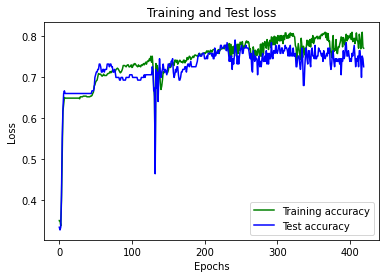

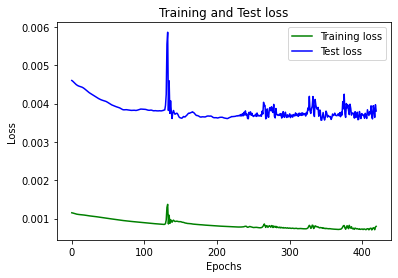

In [82]:
learning_rate = 1e-2

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs = 420,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True,
    train_loader = train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6487804651260376 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010636105434969068 Test Loss: 0.0042345416732132435
Epoch 20 Train Accuracy: 0.6780487895011902 Test Accuracy: 0.673202633857727 Train Loss: 0.0009629401611164212 Test Loss: 0.0038324773777276278
Epoch 30 Train Accuracy: 0.73008131980896 Test Accuracy: 0.7124183177947998 Train Loss: 0.0008726185187697411 Test Loss: 0.003563283709809184
Epoch 40 Train Accuracy: 0.7463414669036865 Test Accuracy: 0.7320261597633362 Train Loss: 0.0008068534079939127 Test Loss: 0.0035165431909263134
Epoch 50 Train Accuracy: 0.7560975551605225 Test Accuracy: 0.7450980544090271 Train Loss: 0.0007848019013181329 Test Loss: 0.003376906970515847
Epoch 60 Train Accuracy: 0.7691056728363037 Test Accuracy: 0.7712418437004089 Train Loss: 0.0007416968583129346 Test Loss: 0.003387600416317582


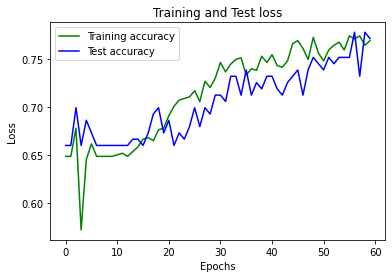

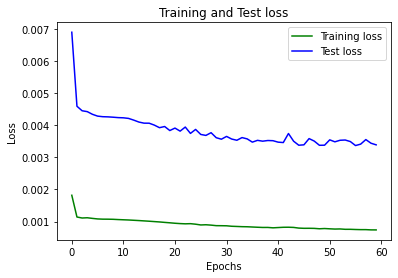

In [101]:
learning_rate = 1e-2

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=60,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6504064798355103 Test Accuracy: 0.6601307392120361 Train Loss: 0.001088081393390894 Test Loss: 0.004359780345112085
Epoch 20 Train Accuracy: 0.6699187159538269 Test Accuracy: 0.6535947918891907 Train Loss: 0.0009856433607637882 Test Loss: 0.003981536719948053
Epoch 30 Train Accuracy: 0.6747967600822449 Test Accuracy: 0.7320261597633362 Train Loss: 0.0009419212583452463 Test Loss: 0.0037232995964586735
Epoch 40 Train Accuracy: 0.7186991572380066 Test Accuracy: 0.7058823704719543 Train Loss: 0.0008730834233574569 Test Loss: 0.0035824114456772804
Epoch 50 Train Accuracy: 0.7512195110321045 Test Accuracy: 0.7058823704719543 Train Loss: 0.0008341794018633664 Test Loss: 0.004107160493731499
Epoch 60 Train Accuracy: 0.7170731425285339 Test Accuracy: 0.7450980544090271 Train Loss: 0.0008660629391670227 Test Loss: 0.0038191184867173433


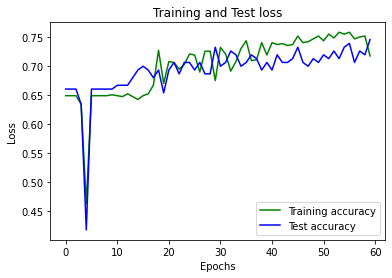

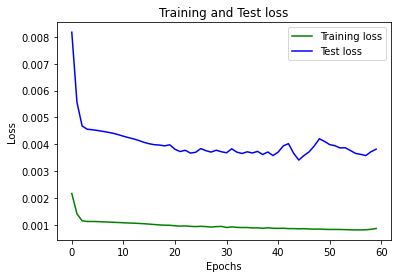

In [100]:
learning_rate = 0.01

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=60,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6536585092544556 Test Accuracy: 0.6928104758262634 Train Loss: 0.0010152988834306598 Test Loss: 0.003945640288293362
Epoch 20 Train Accuracy: 0.720325231552124 Test Accuracy: 0.6928104758262634 Train Loss: 0.0008895872160792351 Test Loss: 0.0037863655015826225
Epoch 30 Train Accuracy: 0.7235772609710693 Test Accuracy: 0.6993464231491089 Train Loss: 0.000865248148329556 Test Loss: 0.003727589501067996
Epoch 40 Train Accuracy: 0.7479674816131592 Test Accuracy: 0.7385621070861816 Train Loss: 0.0008012373000383377 Test Loss: 0.0036907249595969915
Epoch 50 Train Accuracy: 0.7983739972114563 Test Accuracy: 0.7385621070861816 Train Loss: 0.0007498582708649337 Test Loss: 0.0035736977588385344


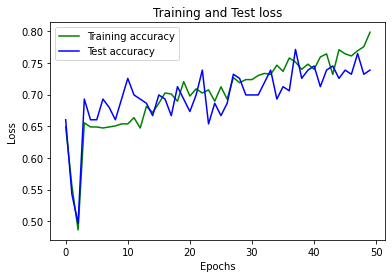

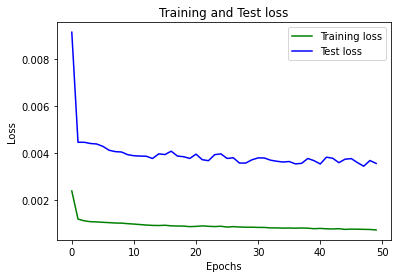

In [104]:
learning_rate = 0.02

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=50,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6487804651260376 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010702405124902725 Test Loss: 0.004218320362269878
Epoch 20 Train Accuracy: 0.6861788630485535 Test Accuracy: 0.6993464231491089 Train Loss: 0.001000651391223073 Test Loss: 0.004039269872009754
Epoch 30 Train Accuracy: 0.7365853786468506 Test Accuracy: 0.7124183177947998 Train Loss: 0.0008806592086330056 Test Loss: 0.0036719145718961954
Epoch 40 Train Accuracy: 0.7528455257415771 Test Accuracy: 0.7385621070861816 Train Loss: 0.0008164846803992987 Test Loss: 0.0035866480320692062
Epoch 50 Train Accuracy: 0.7804877758026123 Test Accuracy: 0.7647058963775635 Train Loss: 0.0007743573514744639 Test Loss: 0.003438354702666402
Epoch 60 Train Accuracy: 0.795121967792511 Test Accuracy: 0.7712418437004089 Train Loss: 0.0007202403503470123 Test Loss: 0.00351713877171278
Epoch 70 Train Accuracy: 0.7495934963226318 Test Accuracy: 0.7320261597633362 Train Loss: 0.0008357632323168218 Test Loss: 0.004110838286

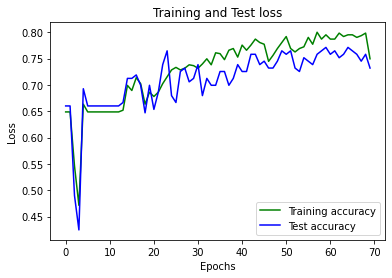

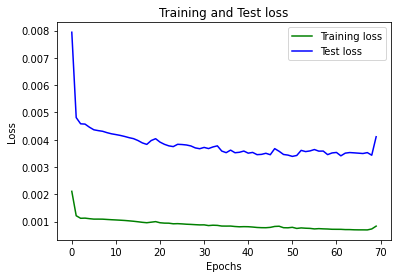

In [105]:
learning_rate = 1e-2

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=70,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6487804651260376 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010505266254767776 Test Loss: 0.004185872618108988
Epoch 20 Train Accuracy: 0.73008131980896 Test Accuracy: 0.7320261597633362 Train Loss: 0.0009109421516768634 Test Loss: 0.003707257332280278
Epoch 30 Train Accuracy: 0.7560975551605225 Test Accuracy: 0.7450980544090271 Train Loss: 0.000814939325209707 Test Loss: 0.003287717467173934
Epoch 40 Train Accuracy: 0.7626016139984131 Test Accuracy: 0.7712418437004089 Train Loss: 0.0008155748946592212 Test Loss: 0.0033030128106474876
Epoch 50 Train Accuracy: 0.7691056728363037 Test Accuracy: 0.7712418437004089 Train Loss: 0.0007815661374479532 Test Loss: 0.0033311336301267147
Epoch 60 Train Accuracy: 0.7788617610931396 Test Accuracy: 0.7647058963775635 Train Loss: 0.000739960465580225 Test Loss: 0.0032408006954938173
Epoch 70 Train Accuracy: 0.7886179089546204 Test Accuracy: 0.7254902124404907 Train Loss: 0.0007072102162055671 Test Loss: 0.003533157287

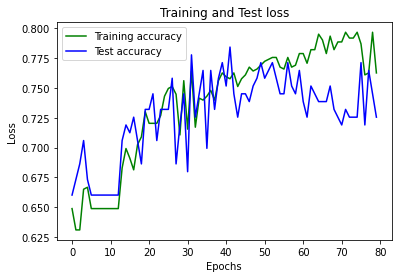

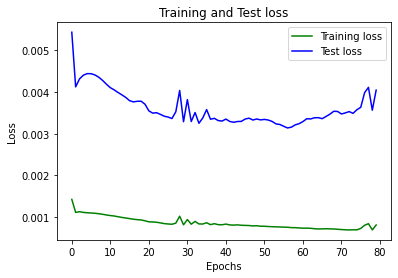

In [106]:
learning_rate = 1e-2

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=80,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6487804651260376 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010766447521746159 Test Loss: 0.0042222635820508
Epoch 20 Train Accuracy: 0.7186991572380066 Test Accuracy: 0.6470588445663452 Train Loss: 0.0009589316323399544 Test Loss: 0.003918114583939314
Epoch 30 Train Accuracy: 0.7349593639373779 Test Accuracy: 0.6601307392120361 Train Loss: 0.000902963918633759 Test Loss: 0.0038854526355862617
Epoch 40 Train Accuracy: 0.7593495845794678 Test Accuracy: 0.7058823704719543 Train Loss: 0.0008437737124040723 Test Loss: 0.003705392125993967


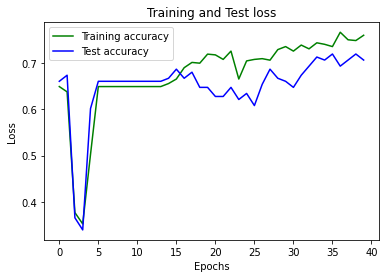

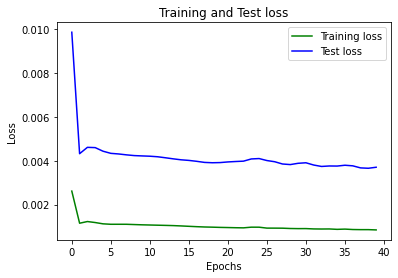

In [107]:
learning_rate = 1e-2

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=40,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6650406718254089 Test Accuracy: 0.6666666865348816 Train Loss: 0.0010598573135212064 Test Loss: 0.0041989730671048164
Epoch 20 Train Accuracy: 0.7056910395622253 Test Accuracy: 0.6601307392120361 Train Loss: 0.0009470701916143298 Test Loss: 0.003935097251087427
Epoch 30 Train Accuracy: 0.7235772609710693 Test Accuracy: 0.6797385811805725 Train Loss: 0.0008914694772101939 Test Loss: 0.0037328428588807583


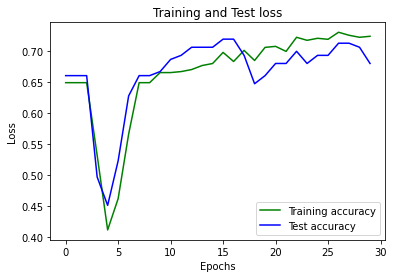

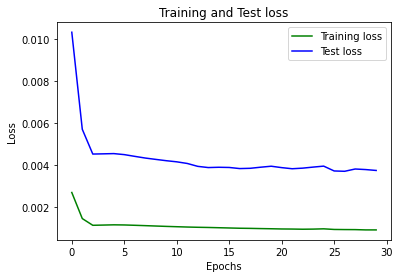

In [108]:
learning_rate = 1e-2

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=30,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6813008189201355 Test Accuracy: 0.673202633857727 Train Loss: 0.0009783545974642038 Test Loss: 0.004081806167960167
Epoch 20 Train Accuracy: 0.7284553050994873 Test Accuracy: 0.7124183177947998 Train Loss: 0.0008769233245402575 Test Loss: 0.003720664419233799
Epoch 30 Train Accuracy: 0.7642276287078857 Test Accuracy: 0.686274528503418 Train Loss: 0.0008022235124371946 Test Loss: 0.003750464878976345
Epoch 40 Train Accuracy: 0.7821138501167297 Test Accuracy: 0.7058823704719543 Train Loss: 0.00077406334457919 Test Loss: 0.0037919485475867987


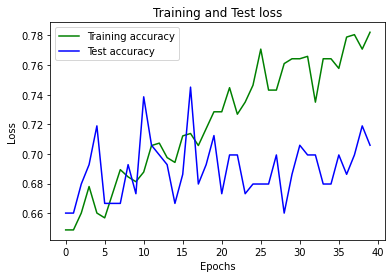

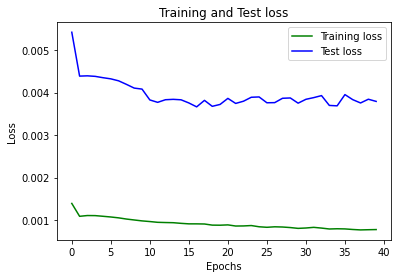

In [109]:
learning_rate = 0.01

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=40,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6504064798355103 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010586950229480863 Test Loss: 0.004202216863632202
Epoch 20 Train Accuracy: 0.70243901014328 Test Accuracy: 0.6993464231491089 Train Loss: 0.0009580416372045875 Test Loss: 0.003787088906392455
Epoch 30 Train Accuracy: 0.7235772609710693 Test Accuracy: 0.7385621070861816 Train Loss: 0.0009017466800287366 Test Loss: 0.003714268561452627
Epoch 40 Train Accuracy: 0.7430894374847412 Test Accuracy: 0.7450980544090271 Train Loss: 0.0008377563790418208 Test Loss: 0.0035216733813285828
Epoch 50 Train Accuracy: 0.7544715404510498 Test Accuracy: 0.758169949054718 Train Loss: 0.0008031108882278204 Test Loss: 0.003439385211095214


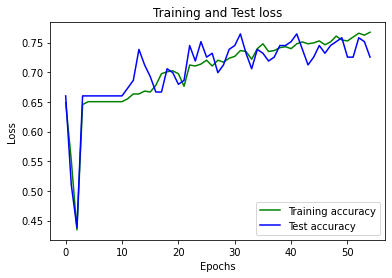

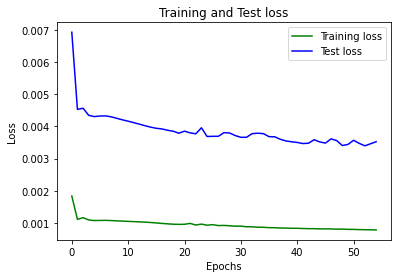

In [110]:
learning_rate = 1e-2

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=55,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6487804651260376 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010753815295174718 Test Loss: 0.00426373491063714
Epoch 20 Train Accuracy: 0.6520324945449829 Test Accuracy: 0.6928104758262634 Train Loss: 0.0010120475199073553 Test Loss: 0.004018059931695461
Epoch 30 Train Accuracy: 0.707317054271698 Test Accuracy: 0.6993464231491089 Train Loss: 0.000941460719332099 Test Loss: 0.003907844424247742
Epoch 40 Train Accuracy: 0.7528455257415771 Test Accuracy: 0.7124183177947998 Train Loss: 0.0008438312797807157 Test Loss: 0.004041214939206839
Epoch 50 Train Accuracy: 0.772357702255249 Test Accuracy: 0.7058823704719543 Train Loss: 0.0008023441187106073 Test Loss: 0.004085594322532415
Epoch 60 Train Accuracy: 0.777235746383667 Test Accuracy: 0.7058823704719543 Train Loss: 0.0007846872904337943 Test Loss: 0.003925609402358532


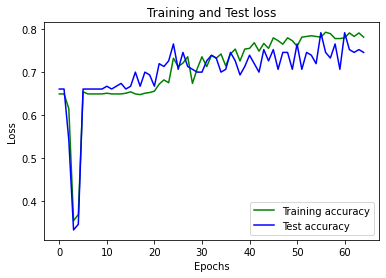

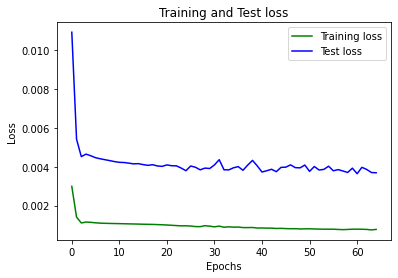

In [111]:
learning_rate = 1e-2

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=65,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

## Final model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10 Train Accuracy: 0.6487804651260376 Test Accuracy: 0.6601307392120361 Train Loss: 0.0010857299203053117 Test Loss: 0.004337773658335209
Epoch 20 Train Accuracy: 0.6796748042106628 Test Accuracy: 0.7189542651176453 Train Loss: 0.0009689010330475867 Test Loss: 0.003777829697355628
Epoch 30 Train Accuracy: 0.720325231552124 Test Accuracy: 0.6928104758262634 Train Loss: 0.0009188143303617835 Test Loss: 0.0037602060474455357
Epoch 40 Train Accuracy: 0.7365853786468506 Test Accuracy: 0.686274528503418 Train Loss: 0.0008525431621819735 Test Loss: 0.0036750766448676586


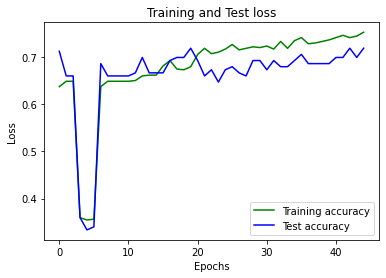

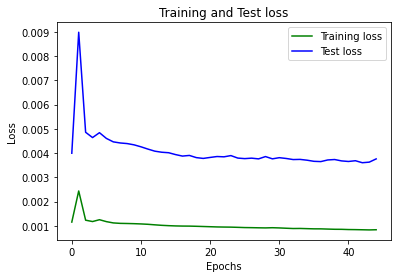

In [112]:
learning_rate = 1e-2

model = Net(len(data[0][0])).to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=45,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)